# Import Libraries

In [1]:
import glob
import matplotlib.pyplot as plt
import os
import tarfile
!pip install timm
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.7 MB/s eta 0:00:00
Mounted at /content/drive


<H1> Extracting Data From .tar.xz file </H1>

In [12]:
tar_file_path = '/content/drive/My Drive/huron_unlabeled_data.tar.xz'
extract_to_path = '/content/extracted_data/Huron_Unlabeled_Data/'

#Tar file extraction function

def extract_tar_xz(tar_file_path, extract_to_path):
    # Creates the specified directory if it doesn't already exist
    os.makedirs(extract_to_path, exist_ok=True)

    # Opens the specified .tar.xz file in read mode
    with tarfile.open(tar_file_path, 'r:xz') as tar:
        print("Extracting files...")

        # Extracts all files from the .tar.xz archive to the specified directory
        tar.extractall(path=extract_to_path)

        print("Extraction completed successfully!")

extract_tar_xz(tar_file_path, extract_to_path)

Extracting files...
Extraction completed successfully!


# Creating Dataset Class

In [13]:
class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, global_transform=None, local_transform=None, num_global_views=2, num_local_views=4):
        """
        Initializes the UnlabeledDataset.

        Input:
        - image_dir (str): The directory containing the image files.
        - global_transform (callable, optional): Transformations applied to generate global views.
        - local_transform (callable, optional): Transformations applied to generate local views.
        - num_global_views (int): Number of global views per image.
        - num_local_views (int): Number of local views per image.

        Output:
        - None: This initializer sets up attributes needed to handle the dataset.
        """

        # Initialize the image directory and retrieve image files
        self.image_dir = image_dir
        self.image_files = glob.glob(os.path.join(image_dir, '**', '*'), recursive=True)

        # Check if any image files were found, otherwise print a warning
        if not self.image_files:
            print("No image files found. Check the extraction path and file extensions.")
        else:
            print(f"Number of images found: {len(self.image_files)}")

        # Store the transformations and number of views
        self.global_transform = global_transform
        self.local_transform = local_transform
        self.num_global_views = num_global_views
        self.num_local_views = num_local_views

    def __len__(self):

        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Retrieves an image and applies transformations to create multiple views.

        Input:
        - idx (int): Index of the image in the dataset.

        Output:
        - list: A list of augmented views for the specified image.
        """

        # Get the path for the image at the specified index
        img_path = self.image_files[idx]

        # Try to open the image, skipping it if an error occurs
        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, OSError) as e:
            print(f"Error loading image at {img_path}: {e}")
            return None

        # Generate multiple augmented views of the image
        views = []

        # Apply global transformations
        for _ in range(self.num_global_views):
            if self.global_transform:
                views.append(self.global_transform(image))

        # Apply local transformations
        for _ in range(self.num_local_views):
            if self.local_transform:
                views.append(self.local_transform(image))

        return views


# Create the **Global** and **Local** Transformations

In [14]:
mean = [0.8786, 0.8474, 0.8732]
std = [0.2504, 0.2687, 0.2513]

# Global (Teacher) Augmentations
global_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Focus on large portions of the image
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply(
        [transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0.02)],
        p=0.8
    ),
    transforms.RandomRotation(degrees=10),
    transforms.RandomApply(
        [transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))],
        p=0.5
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Local (Student) Augmentations
local_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 0.8)),  # Focus on smaller regions
    transforms.RandomVerticalFlip(p=0.3),  # Add vertical flipping
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomApply(
        [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))],
        p=0.3
    ),
    transforms.RandomApply(
        [transforms.RandomRotation(degrees=10)],
        p=0.3
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Standard normalization
])



# Creating the dataset with the 2 global views and 6 local views. Initialzing the batch norm to 128

In [15]:
dataset = UnlabeledDataset(
    image_dir=extract_to_path,
    global_transform=global_transforms,
    local_transform=local_transforms,
    num_global_views=2,  # Adjust as needed
    num_local_views=4    # Adjust as needed
)

#data_loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)

print(len(dataset))

Number of images found: 16353
16353


# Visualize an example and it's transformations

/content/extracted_data/Huron_Unlabeled_Data/Huron_Unlabeled_Data/11623.png


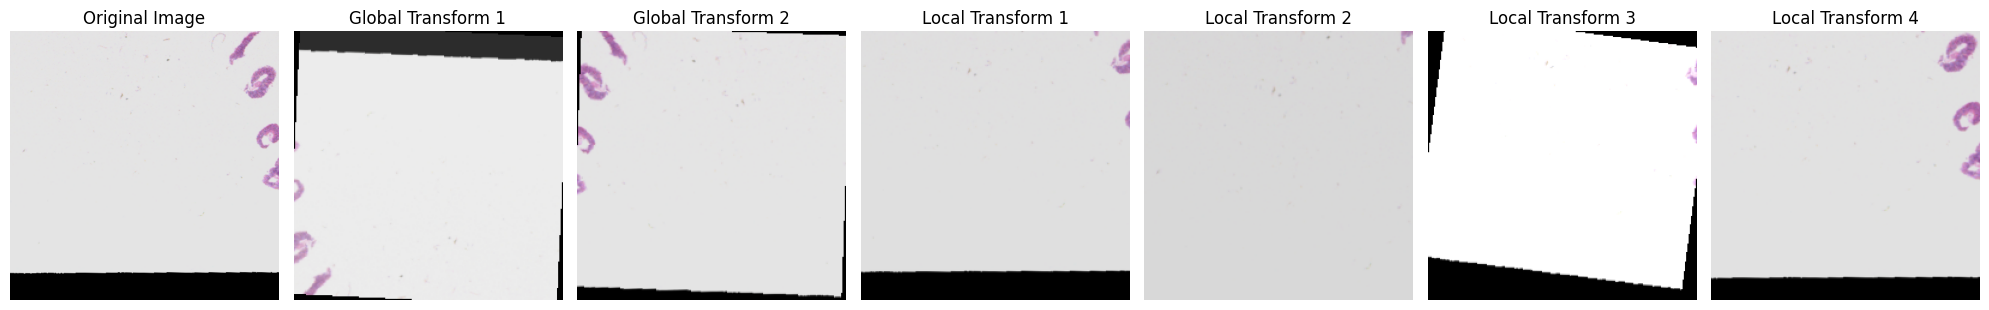

In [21]:
# Get a sample image from the dataset, including the original image

random_val = torch.randint(0, len(dataset), (1,)).item()

original_image = dataset.image_files[random_val]
views = dataset[random_val]
print(original_image)

# Helper function to denormalize and convert a tensor to a displayable format
def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor by reversing the normalization process.

    Input:
    - tensor: A normalized image tensor.
    - mean: List of means used for normalization
    - std: List of standard deviations used for normalization
    Output:
    - tensor: The denormalized tensor.
    """
    tensor = tensor.clone()  # Clone tensor to avoid modifying the original
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Denormalize by multiplying by std and adding mean
    return tensor

def tensor_to_image(tensor, mean, std):
    """
    Converts a denormalized tensor to a PIL image.

    Input:
    - tensor: A normalized image tensor.
    - mean: List of means used for normalization.
    - std: List of standard deviations used for normalization.

    Output:
    - A PIL image that can be displayed.
    """
    tensor = denormalize(tensor, mean, std)  # Denormalize the tensor
    tensor = torch.clamp(tensor, 0, 1)  # Clip values to [0, 1] range for display
    return transforms.ToPILImage()(tensor)  # Convert tensor to PIL image

# Display the original and transformed images
plt.figure(figsize=(20, 5))

# Display the original image
plt.subplot(1, len(views) + 1, 1)  # Add space for the original image
original_image = Image.open(original_image).convert('RGB')  # Open the original image
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Display Transformations
num_global_views = 2
num_local_views = len(views) - num_global_views

# Loop to display each global view
for i in range(num_global_views):
    plt.subplot(1, len(views) + 1, i + 2)
    plt.imshow(tensor_to_image(views[i], mean, std))
    plt.title(f"Global Transform {i + 1}")
    plt.axis('off')

# Loop to display each local view
for i in range(num_global_views, len(views)):
    plt.subplot(1, len(views) + 1, i + 2)
    plt.imshow(tensor_to_image(views[i], mean, std))
    plt.title(f"Local Transform {i - num_global_views + 1}")
    plt.axis('off')

plt.tight_layout()  # Adjust layout for clear spacing
plt.show()

In [ ]:
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=2048, bottleneck_dim=256):
        super(DINOHead, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))

    def forward(self, x):
        x = self.mlp(x)
        x = F.normalize(x, dim=-1, p=2)
        return self.last_layer(x)

In [ ]:
class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs, nepochs, student_temp=0.1,
                 center_momentum=0.9):
        super(DINOLoss, self).__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops

        # Initialize the center buffer to zero with the specified output dimension
        self.register_buffer("center", torch.zeros(1, out_dim))

        # Create a schedule for the teacher's temperature over the training epochs
        self.teacher_temp_schedule = torch.cat((
            torch.linspace(warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs),
            torch.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        device = student_output.device
        self.center = self.center.to(device)

        # Normalize and split the student output
        student_out = student_output / self.student_temp
        student_out = torch.chunk(student_out, self.ncrops)

        # Normalize and split the teacher output
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(self.ncrops)

        # Compute DINO loss
        total_loss = sum(
            torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1).mean()
            for iq, q in enumerate(teacher_out)
            for v in range(len(student_out))
            if v != iq
        )

        n_loss_terms = self.ncrops * (self.ncrops - 1)
        return total_loss / n_loss_terms

    @torch.no_grad()
    def update_center(self, teacher_output):
        batch_center = teacher_output.mean(dim=0, keepdim=True)
        self.center.mul_(self.center_momentum).add_(batch_center * (1 - self.center_momentum))

In [ ]:
base_model = timm.create_model('vit_small_patch16_224', pretrained=False)
in_dim = base_model.head.in_features
base_model.head = DINOHead(in_dim, out_dim=8192)

#Checkpoint for epochs. Leave null to start from epoch 1
checkpoint_path = '/content/base_model_epoch_8.pth'

if checkpoint_path:
    base_model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

teacher_model = timm.create_model('vit_small_patch16_224', pretrained=False)
teacher_model.head = DINOHead(in_dim, out_dim=8192)
teacher_model.load_state_dict(base_model.state_dict())
teacher_model.eval()

# Freeze teacher model parameters
for param in teacher_model.parameters():
    param.requires_grad = False

# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
# Optimizer
optimizer = optim.AdamW(base_model.parameters(), lr=0.001, weight_decay=0.05)
num_epochs = 10

# Instantiate the DINO loss with centering
dino_loss_fn = DINOLoss(
    out_dim=8192,
    ncrops=6,
    warmup_teacher_temp=0.04,
    teacher_temp=0.07,
    warmup_teacher_temp_epochs=10,
    nepochs=num_epochs,
    student_temp=0.1,
    center_momentum=0.9
).to(device)


checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    base_model.train()
    total_loss = 0.0
    print(f"\nStarting epoch {epoch + 1}/{num_epochs}...")

    for i, images in enumerate(data_loader):
        images = [img.to(device) for img in images]

        # Forward pass through the student model
        student_outputs = [base_model(img) for img in images]
        student_output = torch.cat(student_outputs)  # Combine into one tensor for loss calculation

        # Forward pass through the teacher model (no gradients)
        with torch.no_grad():
            teacher_outputs = [teacher_model(img) for img in images]
            teacher_output = torch.cat(teacher_outputs)  # Combine into one tensor

        # Compute DINO loss with centering
        loss = dino_loss_fn(student_output, teacher_output, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EMA update for the teacher model
        with torch.no_grad():
            for teacher_param, student_param in zip(teacher_model.parameters(), base_model.parameters()):
                teacher_param.data.mul_(0.996).add_((1 - 0.996) * student_param.data)

        total_loss += loss.item()
        print(f"Batch {i + 1}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    # Save model weights after each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"base_model_epoch_{epoch + 1}.pth")
    torch.save(base_model.state_dict(), checkpoint_path)
    print(f"Model weights saved to {checkpoint_path}")




Starting epoch 1/20...
Error loading image at /content/extracted_data/Huron_Unlabeled_Data/Huron_Unlabeled_Data: [Errno 21] Is a directory: '/content/extracted_data/Huron_Unlabeled_Data/Huron_Unlabeled_Data'


TypeError: object of type 'NoneType' has no len()

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Number of images found: 16352


<ipython-input-16-a6fd5b0fdf62>:57: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=5, cmap='viridis')


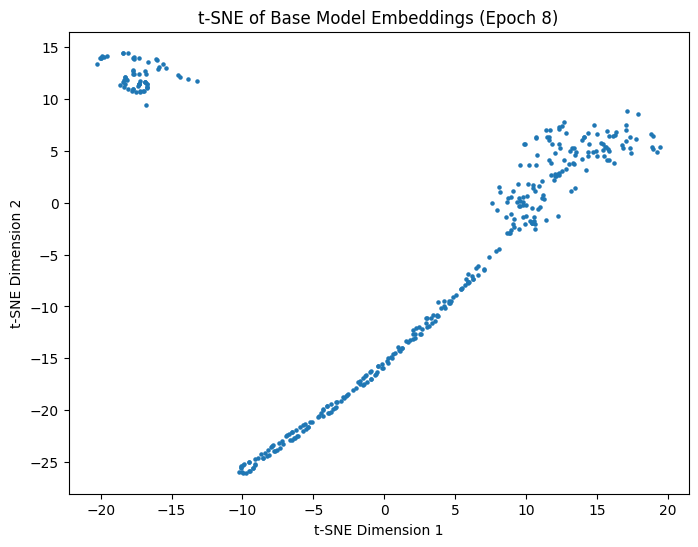

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load the base model and checkpoint
base_model = timm.create_model('vit_small_patch16_224', pretrained=False)
in_dim = base_model.head.in_features
base_model.head = DINOHead(in_dim, out_dim=8192)

# Load the saved checkpoint
checkpoint_path = 'base_model_epoch_8.pth'
base_model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'), weights_only=True))
base_model.eval()

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

# Prepare the dataset and dataloader
image_dir = extract_to_path  # Path where images were extracted
dataset = CustomImageDataset(
    image_dir=image_dir,
    global_transform=global_transform,
    local_transform=local_transform,
    num_global_views=2,
    num_local_views=4
)
data_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

# Extract embeddings from a single batch of images for t-SNE
embeddings = []
with torch.no_grad():
    for i, images in enumerate(data_loader):
        if i == 1:  # Only get embeddings from the first batch to limit data size
            break
        images = [img.to(device) for img in images]
        batch_embeddings = [base_model(img).cpu().numpy() for img in images]
        embeddings.append(np.concatenate(batch_embeddings, axis=0))

# Concatenate embeddings for t-SNE
embeddings = np.concatenate(embeddings, axis=0)

# # Scale embeddings before t-SNE
scaler = MinMaxScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# # Apply t-SNE
tsne = TSNE(n_components=2, perplexity=40, learning_rate=1000, max_iter=3000, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_scaled)

# # Plot t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=5, cmap='viridis')
plt.title('t-SNE of Base Model Embeddings (Epoch 8)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
labelled_data = '/content/labelled_data'
tar_file_path1 = '/content/Preview_Tiles_Faint_Tissue.tar.xz'
tar_file_path2 = '/content/Preview_Tiles_Ink_Marks.tar.xz'
tar_file_path3 = '/content/Preview_Tiles_Large_Solid_Tissue.tar.xz'
tar_file_path4 = '/content/Preview_Tiles_Small_Fragmented_Tissue.tar.xz'
tar_file_path5 = '/content/Preview_Tiles_Faint_Tissue.tar.xz'
tar_file_path6 = '/content/Preview_Tiles_Faint_Tissue.tar.xz'
tar_file_path7 = '/content/Preview_Tiles_Faint_Tissue.tar.xz'

def extract_tar_xz(tar_file_path, extract_to_path):
    os.makedirs(extract_to_path, exist_ok=True)
    with tarfile.open(tar_file_path, 'r:xz') as tar:
        print("Extracting files...")
        tar.extractall(path=extract_to_path)
        print("Extraction completed successfully!")

extract_tar_xz(tar_file_path, labelled_data)